In [1]:
import numpy as np
import pandas as pd #this might need to be installed
import datetime
import matplotlib.pyplot as plt
import statistics as sts
from scipy.optimize import minimize,least_squares
from sympy import symbols, diff
from sympy.functions import exp
from iminuit import Minuit
#import ROOT

    # "from fibertest_fncts import frdmunits,unpack_data,unpack_and_throw_outliers" Instead we do
frdmunits=2.54 #cm/inch
def unpack_data(datafile,npos,size):

    data_list=np.transpose(np.array(pd.read_csv(datafile)))

    points=int((len(data_list)-6)/2) # This is the number of data points taken
    #size is the number of data points we want to unpack
    newpmtstd=np.empty(npos)
    newpmtmean=np.empty(npos)
    newsipmstd=np.empty(npos)
    newsipmmean=np.empty(npos)

    npmtoutlier=0
    nsipmoutlier=0

    for i in range(npos):
        np.transpose(data_list)[i][2:-(2*points-size+4)]
        stdev_pmt=sts.stdev(np.transpose(data_list)[i][2:-(2*points-size+4)])
        avg_pmt=sts.mean(np.transpose(data_list)[i][2:-(2*points-size+4)])
        newpmtdata=[]

        np.transpose(data_list)[i][-(points+4):-(4+(points-size))]
        stdev_sipm=sts.stdev(np.transpose(data_list)[i][-(points+4):-(4+(points-size))])
        avg_sipm=sts.mean(np.transpose(data_list)[i][-(points+4):-(4+(points-size))])
        newsipmdata=[]


        for j in range(len(np.transpose(data_list)[i][2:-(points-size+4)])):
            if np.transpose(data_list)[i][j+2]<avg_pmt+2*stdev_pmt and np.transpose(data_list)[i][j+2]>avg_pmt-2*stdev_pmt:
                newpmtdata.append(np.transpose(data_list)[i][j+2])
                #print("good")
            else:
                npmtoutlier+=1

        for j in range(len(np.transpose(data_list)[i][-(points+4):-(4+(points-size))])):
            if np.transpose(data_list)[i][j+points+2]<avg_sipm+2*stdev_sipm and np.transpose(data_list)[i][j+points+2]>avg_sipm-2*stdev_sipm:
                newsipmdata.append(np.transpose(data_list)[i][j+points+2])
                #print("good")
            else:
                nsipmoutlier+=1

        newpmtstd[i]=sts.stdev(newpmtdata)*10**6
        newpmtmean[i]=-sts.mean(newpmtdata)*10**6
        newsipmstd[i]=sts.stdev(newsipmdata)*10**6
        newsipmmean[i]=-sts.mean(newsipmdata)*10**6
        #print(size-len(newpmtdata))
    return np.array([newpmtmean,newpmtstd,newsipmmean,newsipmstd])
def unpack_and_throw_outliers(filename,runs):
    pmt_mean_old=-np.transpose(np.array(pd.read_csv(filename)))[-4]*10**6
    pmt_std_old=np.transpose(np.array(pd.read_csv(filename)))[-3]*10**6
    pmt_data=np.transpose(np.array(pd.read_csv(filename)))[2:-(runs+4)]*10**6 # all data taken by the pmt per position
    sipm_data=np.transpose(np.array(pd.read_csv(filename)))[-(runs+4):-4]*10**6 # all data taken by the sipm per position
    
    pmt_data_no_outliers=[]
    sipm_data_no_outliers=[]
    pmt_data_no_outliers_means=[]
    pmt_data_no_outliers_std=[]
    for i in range(25):
        data=np.transpose(pmt_data)[i]
        det_data=np.transpose(sipm_data)[i]
        # Create a box plot
        box_props = plt.boxplot(data)
        
       # plt.show()

        # Get the whisker ranges
        lower_whisker = box_props['whiskers'][0].get_ydata()[1]
        upper_whisker = box_props['whiskers'][1].get_ydata()[1]

        # Identify outliers using IQR method
        iqr = upper_whisker - lower_whisker
        lower_bound = lower_whisker
        upper_bound = upper_whisker

        outliers = np.where((data < lower_bound) | (data > upper_bound))[0]
        #print(outliers,lower_bound,upper_bound)
    
         # Remove outliers from the data
        no_outlier_pmt_data = -np.delete(data, outliers)
        no_outlier_sipm_data = np.delete(det_data, outliers)
        
        pmt_data_no_outliers.append(no_outlier_pmt_data)
        sipm_data_no_outliers.append(no_outlier_sipm_data)

        pmt_data_no_outliers_means.append(np.mean(no_outlier_pmt_data))
        pmt_data_no_outliers_std.append(np.std(no_outlier_pmt_data))
    
    
    fig = plt.figure(figsize=(16, 10), dpi=80)
    # Error propagation formula for the ratio
    #err = (lsr_crctd_data_mean/pmt_mean_old) * np.sqrt((lsr_crctd_data_stdev / lsr_crctd_data_mean)**2 + (pmt_std_old / pmt_mean_old)**2)
    err = (pmt_data_no_outliers_std/pmt_mean_old)
    plt.errorbar(pos,pmt_data_no_outliers_means/pmt_mean_old,yerr=err, fmt="o", color="k",capsize=5,label='Ratio of corrected to raw data')
    #plt.errorbar(pos,pmt_mean_old, yerr=pmt_std_old, fmt="o", color="b",capsize=5,label='Fiber')
    plt.legend()
    plt.show()
    return         pmt_data_no_outliers, sipm_data_no_outliers, pmt_data_no_outliers_means, pmt_data_no_outliers_std

# Getting data from Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

x0=(1.5+2.75)*2.54 #cm/inch
Len=207.6#(4+73.5)*2.54+x0 #cm/inch
L_err=0.125*frdmunits
pos=np.transpose(np.array(pd.read_csv("fibertest_002150.csv")))[0]*frdmunits+x0
pos_zero=np.concatenate((pos, [0.]))

#Fibers 
cut="fibertest_002150.csv"
ref="fibertest_002151.csv"

In [2]:
cut_fiber2_pmt_data=np.transpose(np.transpose(np.array(pd.read_csv(cut)))[2:-104])
cut_fiber2_sipm_data=np.transpose(np.transpose(np.array(pd.read_csv(cut)))[-104:-4])
cut_fiber2_pmt_means=np.transpose(np.transpose(np.array(pd.read_csv(cut)))[-4])
cut_fiber2_pmt_std=np.transpose(np.transpose(np.array(pd.read_csv(cut)))[-3])
cut_fiber2_sipm_means=np.transpose(np.transpose(np.array(pd.read_csv(cut)))[-2])
cut_fiber2_sipm_std=np.transpose(np.transpose(np.array(pd.read_csv(cut)))[-1])

ref_fiber2_pmt_data=np.transpose(np.transpose(np.array(pd.read_csv(ref)))[2:-104])
ref_fiber2_sipm_data=np.transpose(np.transpose(np.array(pd.read_csv(ref)))[-104:-4])
ref_fiber2_pmt_means=np.transpose(np.transpose(np.array(pd.read_csv(ref)))[-4])
ref_fiber2_pmt_std=np.transpose(np.transpose(np.array(pd.read_csv(ref)))[-3])
ref_fiber2_sipm_means=np.transpose(np.transpose(np.array(pd.read_csv(ref)))[-2])
ref_fiber2_sipm_std=np.transpose(np.transpose(np.array(pd.read_csv(ref)))[-1])

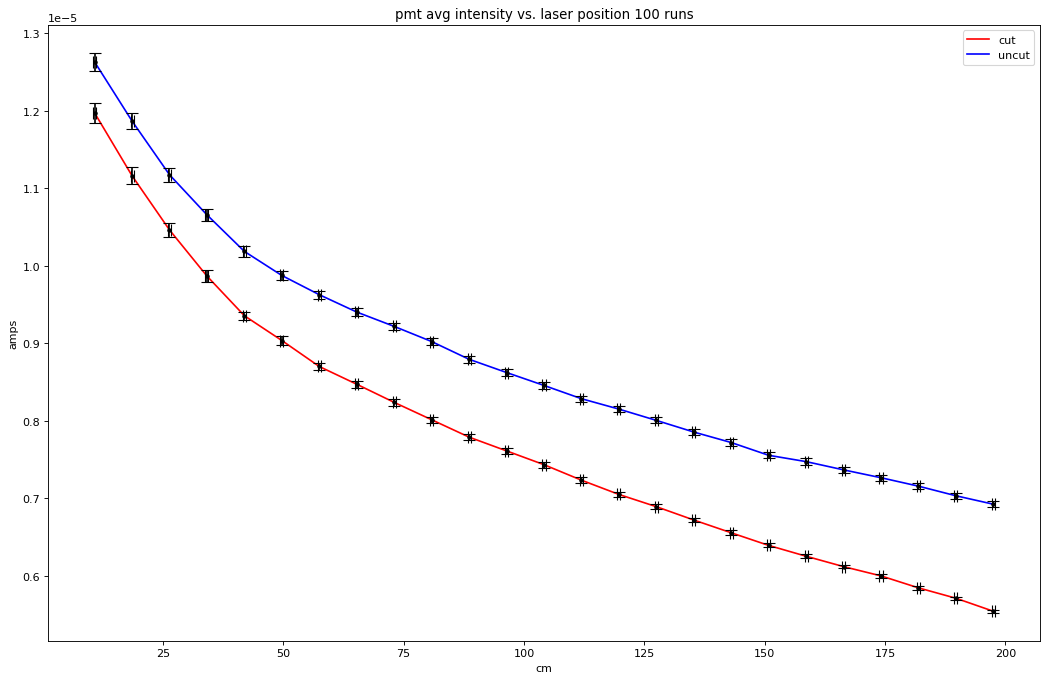

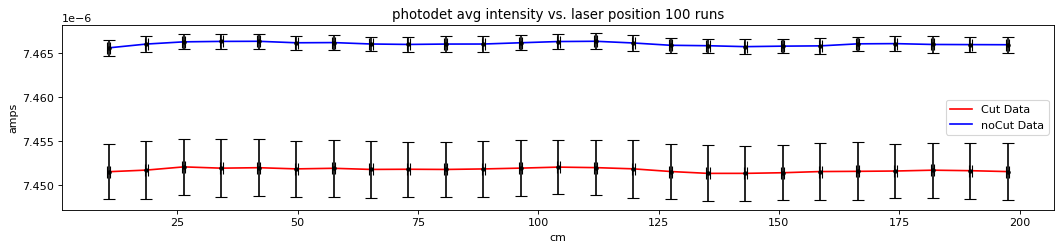

ValueError: 'yerr' must not contain negative values

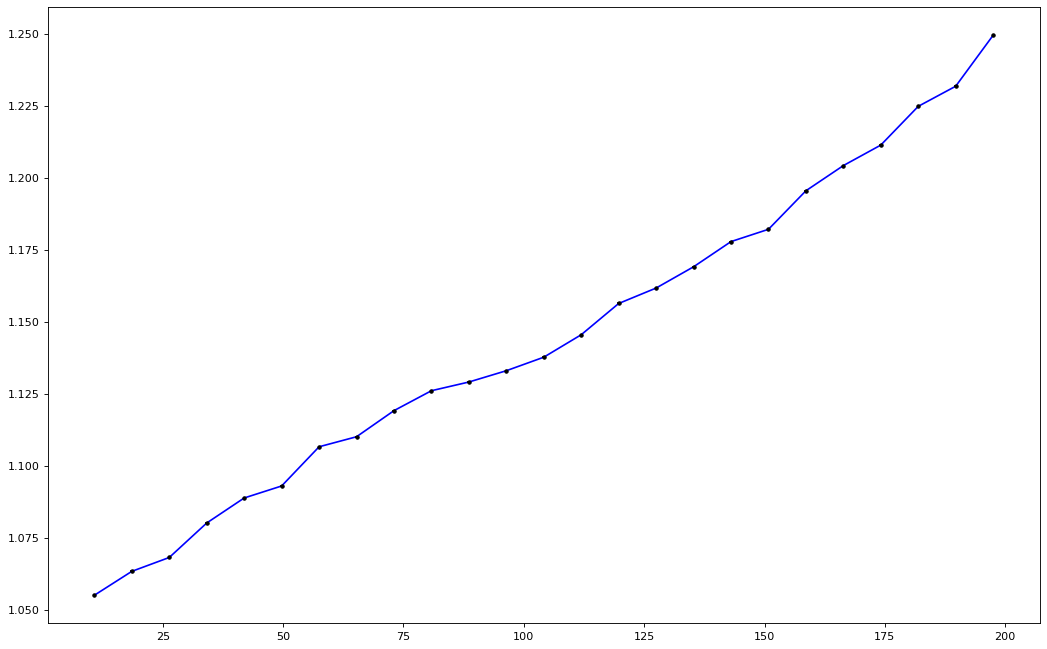

In [3]:
#a_scale_factor=np.mean(refurb_fiber2_sipm_means)/np.mean(fiber2_sipm_means)
fig = plt.figure(figsize=(16, 10), dpi=80)
plt.plot(pos,-cut_fiber2_pmt_means,color='r')
plt.errorbar(pos,-cut_fiber2_pmt_means, xerr=L_err,yerr=cut_fiber2_pmt_std, fmt=".", color="k",capsize=5)
plt.plot(pos,-ref_fiber2_pmt_means,color='b')
plt.errorbar(pos,-ref_fiber2_pmt_means, xerr=L_err, yerr=ref_fiber2_pmt_std, fmt=".", color="k",capsize=5)
plt.title("pmt avg intensity vs. laser position 100 runs")
plt.xlabel("cm")
plt.ylabel("amps")
plt.legend(['cut', 'uncut'])
plt.show()
fig = plt.figure(figsize=(16, 3), dpi=80)
plt.plot(pos,cut_fiber2_sipm_means,color='r')
plt.errorbar(pos,cut_fiber2_sipm_means, xerr=L_err,yerr=cut_fiber2_sipm_std, fmt=".", color="k",capsize=5)
plt.plot(pos,ref_fiber2_sipm_means,color='b')
plt.errorbar(pos,ref_fiber2_sipm_means, xerr=L_err,yerr=ref_fiber2_sipm_std, fmt=".", color="k",capsize=5)
plt.title("photodet avg intensity vs. laser position 100 runs")
plt.xlabel("cm")
plt.ylabel("amps")
plt.legend(['Cut Data', 'noCut Data'])
plt.show()

fig = plt.figure(figsize=(16, 10), dpi=80)
plt.plot(pos,ref_fiber2_pmt_means/cut_fiber2_pmt_means,color='b')
plt.errorbar(pos,ref_fiber2_pmt_means/cut_fiber2_pmt_means, xerr=L_err, yerr=ref_fiber2_pmt_std/cut_fiber2_pmt_means, fmt=".", color="k",capsize=5)
plt.title("Ratio of uncut fiber to cut fiber")
plt.show()

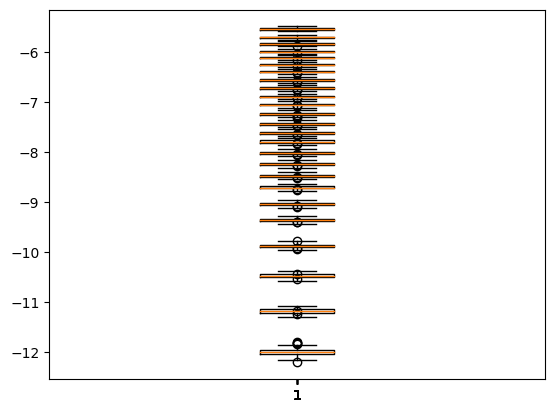

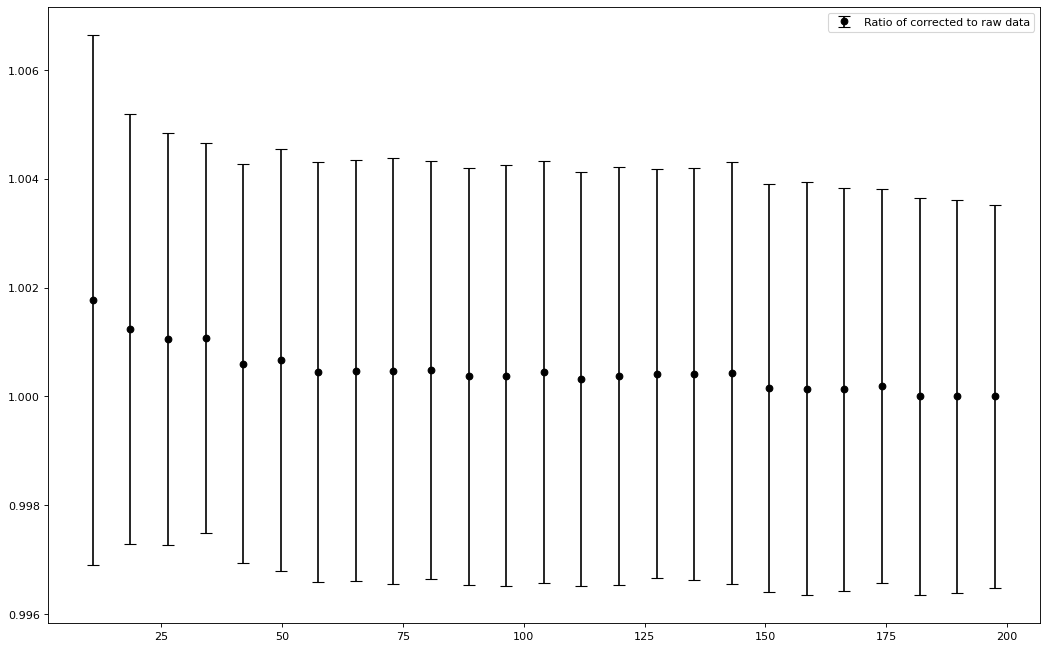

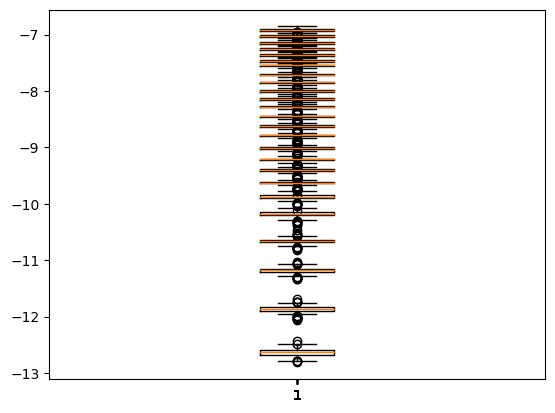

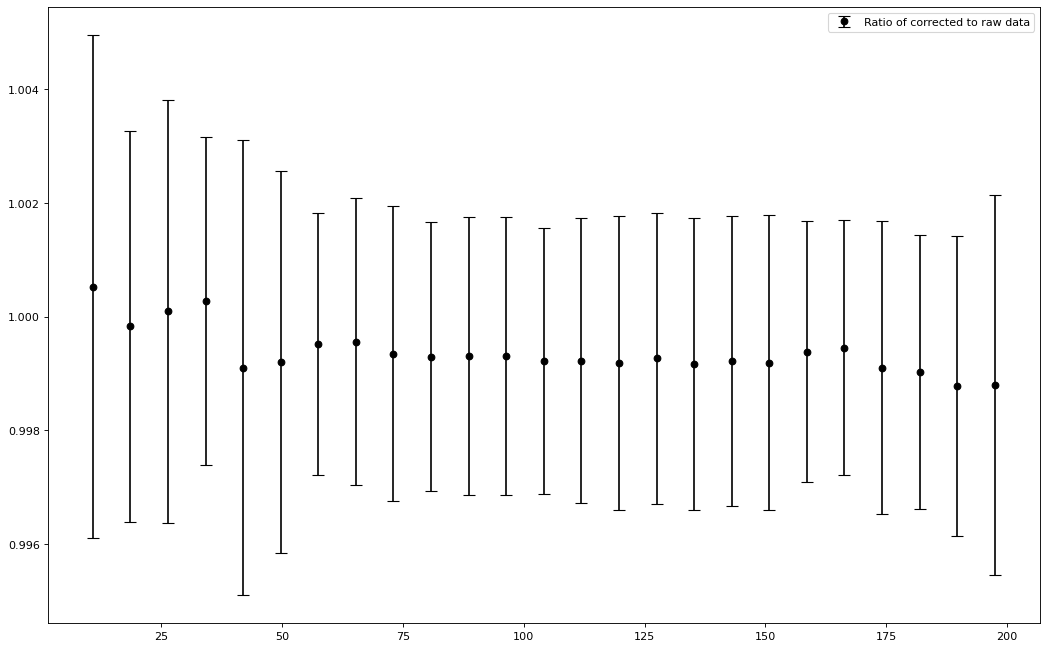

In [4]:
pmt_cut_no_outliers,det_cut_no_outliers,pmt_cut_no_outliers_means, pmt_cut_no_outliers_std=unpack_and_throw_outliers(cut,100)
pmt_ref_no_outliers,det_ref_no_outliers,pmt_ref_no_outliers_means, pmt_ref_no_outliers_std=unpack_and_throw_outliers(ref,100)

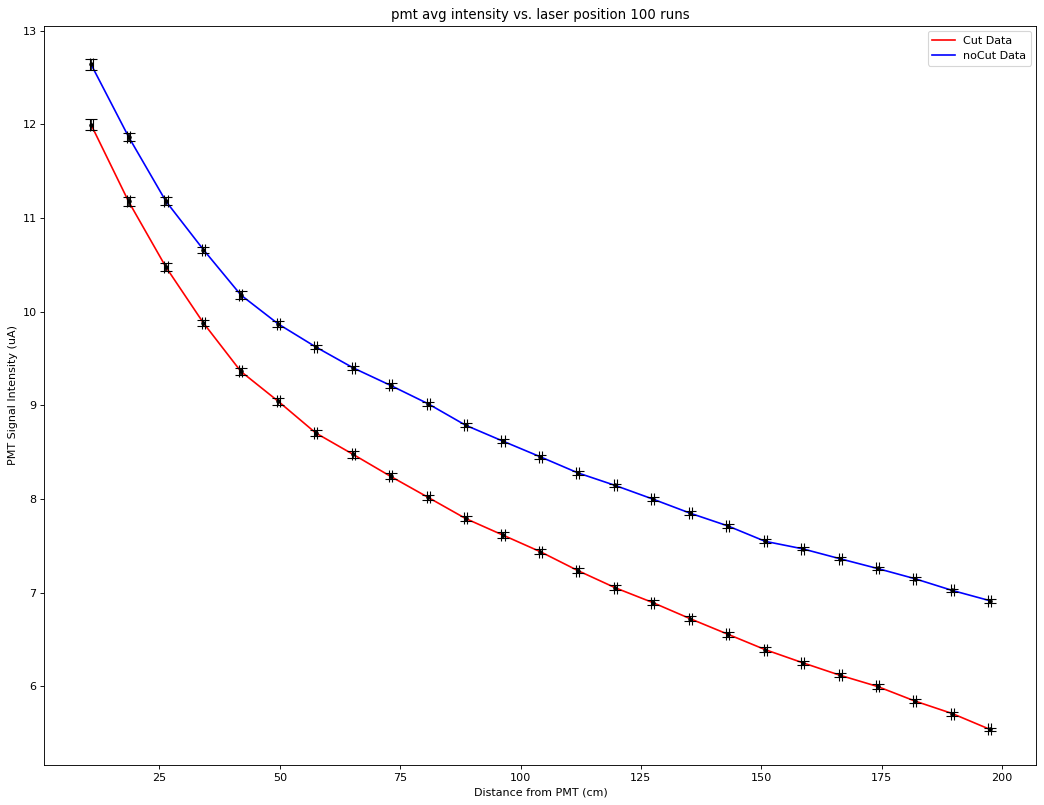

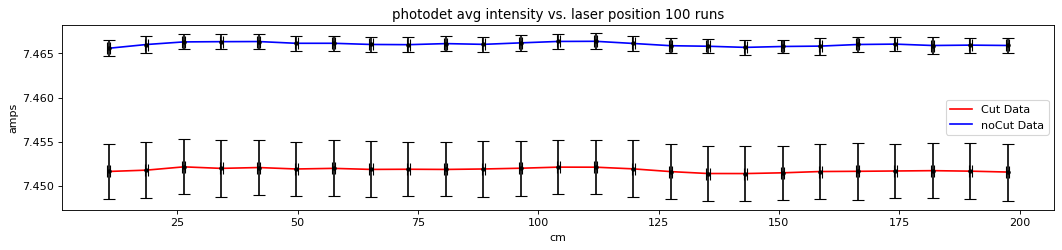

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


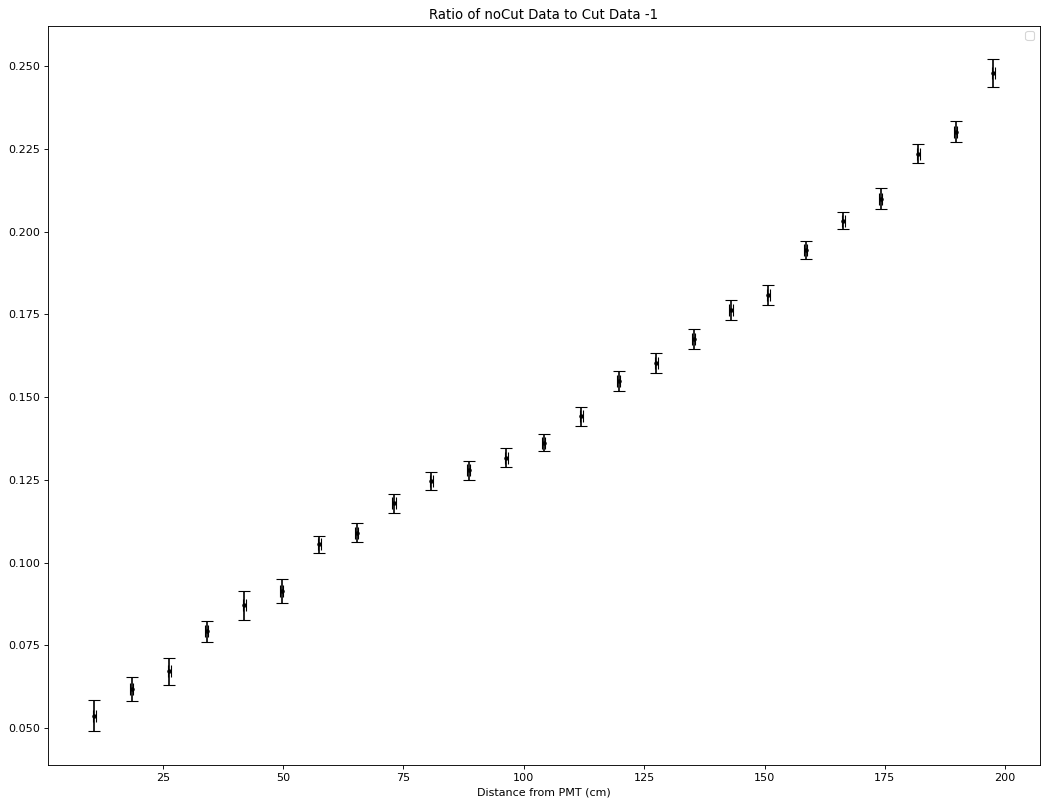

In [5]:
cut_det_data_no_outliers_means=np.empty(25)
cut_det_data_no_outliers_std=np.empty(25)

for i in range(25):
    cut_det_data_no_outliers_means[i]=np.mean(det_cut_no_outliers[i])
    cut_det_data_no_outliers_std[i]=np.std(det_cut_no_outliers[i])

ref_det_data_no_outliers_means=np.empty(25)
ref_det_data_no_outliers_std=np.empty(25)

for i in range(25):
    ref_det_data_no_outliers_means[i]=np.mean(det_ref_no_outliers[i])
    ref_det_data_no_outliers_std[i]=np.std(det_ref_no_outliers[i])

#a_scale_factor=np.mean(refurb_fiber2_sipm_means)/np.mean(fiber2_sipm_means)
fig = plt.figure(figsize=(16, 12), dpi=80)
plt.plot(pos,pmt_cut_no_outliers_means,color='r')
plt.errorbar(pos,pmt_cut_no_outliers_means, xerr=L_err,yerr=pmt_cut_no_outliers_std, fmt=".", color="k",capsize=5)
plt.plot(pos,pmt_ref_no_outliers_means,color='b')
plt.errorbar(pos,pmt_ref_no_outliers_means, xerr=L_err, yerr=pmt_ref_no_outliers_std, fmt=".", color="k",capsize=5)
plt.title("pmt avg intensity vs. laser position 100 runs")
plt.xlabel("Distance from PMT (cm)")
plt.ylabel("PMT Signal Intensity (uA)")
plt.legend(['Cut Data', 'noCut Data'])
plt.show()

fig = plt.figure(figsize=(16, 3), dpi=80)
plt.plot(pos,cut_det_data_no_outliers_means,color='r')
plt.errorbar(pos,cut_det_data_no_outliers_means, xerr=L_err,yerr=cut_det_data_no_outliers_std, fmt=".", color="k",capsize=5)
plt.plot(pos,ref_det_data_no_outliers_means,color='b')
plt.errorbar(pos,ref_det_data_no_outliers_means, xerr=L_err,yerr=ref_det_data_no_outliers_std, fmt=".", color="k",capsize=5)
plt.title("photodet avg intensity vs. laser position 100 runs")
plt.xlabel("cm")
plt.ylabel("amps")
plt.legend(['Cut Data', 'noCut Data'])
plt.show()

fig = plt.figure(figsize=(16, 12), dpi=80)
#plt.plot(pos,np.array(pmt_data_no_outliers_means)/np.array(cut_pmt_data_no_outliers_means)-1,color='b',label='Percent of reflected light')
plt.errorbar(pos,np.array(pmt_ref_no_outliers_means)/np.array(pmt_cut_no_outliers_means)-1, xerr=L_err, yerr=np.array(pmt_ref_no_outliers_std)/np.array(pmt_cut_no_outliers_means), fmt=".", color="k",capsize=5)
plt.title("Ratio of noCut Data to Cut Data -1")
plt.legend()
plt.xlabel("Distance from PMT (cm)")
#plt.ylabel("amps")
plt.show()

In [6]:
def Attenuation(x, a, A_L, A_S ):
    return (a*np.exp(-(x)/A_L)+np.abs(1-a)*np.exp(-(x)/A_S))
def Attenuation_w_Reflection(x, a, A_L, A_S, R,L):
    return Attenuation(x,a,A_L,A_S)+R*Attenuation(2*L-x,a,A_L,A_S)

def minimize_without_reflection_cut(Q, a, A_L, A_S):
    res=(pmt_cut_no_outliers_means-Q*Attenuation(pos,a,A_L,A_S))/pmt_cut_no_outliers_std
    return np.sum(res**2)
def minimize_with_reflection_ref(Q, a, A_L, A_S,R):
    res=(pmt_ref_no_outliers_means-Q*Attenuation_w_Reflection(pos,a,A_L,A_S,R,Len))/pmt_ref_no_outliers_std
    return np.sum(res**2)

In [7]:
# Individual Fits

#Cut
# Create a Minuit object
cut_Min = Minuit(minimize_without_reflection_cut, Q=10, a=.73, A_L=350, A_S=20)

# Perform the minimization
result = cut_Min.migrad()

# Print the result
print("Minimization result: Fiber without Reflection (Cut)")
print(result)
cov_matrix_cut=cut_Min.covariance
param_errors=cut_Min.errors
corr_matrix_cut = cov_matrix_cut / np.outer(param_errors, param_errors)
print(corr_matrix_cut)
print("Optimal parameters:", cut_Min.values)
print("Parameters Errors:", cut_Min.errors)

#Refurb
# Create a Minuit object
ref_Min = Minuit(minimize_with_reflection_ref, Q=13.8, a=.73, A_L=350, A_S=20,R=0.5)


# Perform the minimization
result = ref_Min.migrad()

# Print the result
print("Minimization result: Fiber with Reflection (Refurb)")
print(result)
cov_matrix_ref=ref_Min.covariance
param_errors=ref_Min.errors
corr_matrix_ref = cov_matrix_ref / np.outer(param_errors, param_errors)
print(corr_matrix_ref)
print("Optimal parameters:", ref_Min.values)
print("Parameters Errors:", ref_Min.errors)

Minimization result: Fiber without Reflection (Cut)
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 15.93                      │              Nfcn = 346              │
│ EDM = 9.94e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬

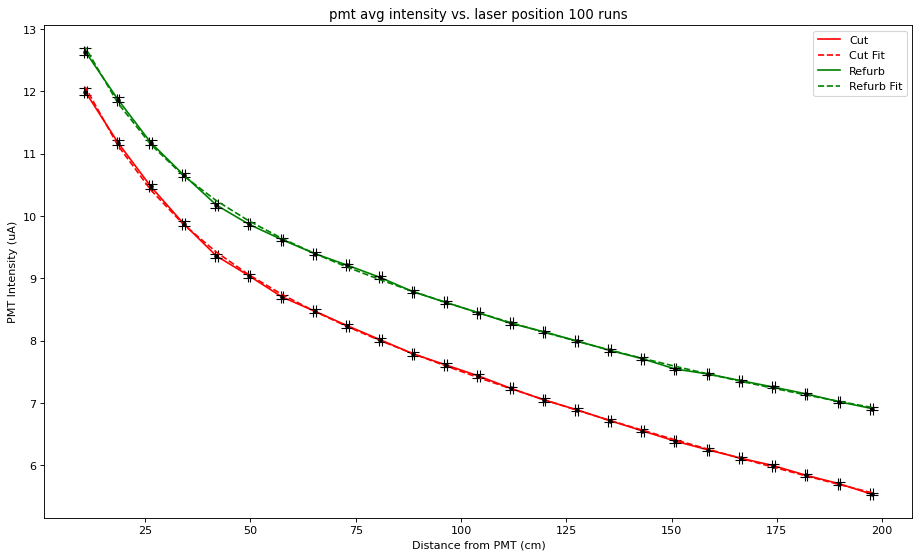

In [8]:
# Individual Fits (One Graph)
cut_fit=cut_Min.values['Q']*Attenuation(pos,cut_Min.values['a'],cut_Min.values['A_L'],cut_Min.values['A_S'])
ref_fit=ref_Min.values['Q']*Attenuation_w_Reflection(pos,ref_Min.values['a'],ref_Min.values['A_L'],ref_Min.values['A_S'],ref_Min.values['R'],Len)

fig = plt.figure(figsize=(14, 8), dpi=80)
plt.plot(pos,pmt_cut_no_outliers_means,color='r')
plt.errorbar(pos,pmt_cut_no_outliers_means, xerr=L_err,yerr=pmt_cut_no_outliers_std, fmt=".", color="k",capsize=5)
plt.plot(pos,cut_fit,color='r', linestyle='dashed')
plt.plot(pos,pmt_ref_no_outliers_means,color='g')
plt.errorbar(pos,pmt_ref_no_outliers_means, xerr=L_err,yerr=pmt_ref_no_outliers_std, fmt=".", color="k",capsize=5)
plt.plot(pos,ref_fit,color='g', linestyle='dashed')
plt.title("pmt avg intensity vs. laser position 100 runs")
plt.xlabel("Distance from PMT (cm)")
plt.ylabel("PMT Intensity (uA)")
plt.legend(['Cut','Cut Fit','Refurb','Refurb Fit'])
plt.show()

In [9]:
# Joint
def joint_minimization(Q,a,A_L,A_S,R):
    data=np.concatenate([pmt_ref_no_outliers_means,pmt_cut_no_outliers_means])
    model=Q*np.concatenate([Attenuation_w_Reflection(pos,a,A_L,A_S,R,Len),Attenuation(pos,a,A_L,A_S)])
    err=np.concatenate([pmt_ref_no_outliers_std,pmt_cut_no_outliers_std])
    cost=(data-model)/err
    return np.sum(cost**2)

# Create a Minuit object
Joint_Min = Minuit(joint_minimization, Q=11, a=.5, A_L=450, A_S=20, R=0)

# Perform the minimization
result = Joint_Min.migrad()

print("Minimization result: Joint Fit")
print(result)
cov_matrix_Joint=Joint_Min.covariance
param_errors2=Joint_Min.errors
corr_matrix_Joint = cov_matrix_Joint / np.outer(param_errors2, param_errors2)
print(corr_matrix_Joint)
print("Optimal parameters:", Joint_Min.values)
print("Parameters Errors:", Joint_Min.errors)


ref_Joint_fit=Joint_Min.values['Q']*Attenuation_w_Reflection(pos,Joint_Min.values['a'],Joint_Min.values['A_L'],Joint_Min.values['A_S'],Joint_Min.values['R'],Len)
cut_Joint_fit=Joint_Min.values['Q']*Attenuation(pos,Joint_Min.values['a'],Joint_Min.values['A_L'],Joint_Min.values['A_S'])

Minimization result: Joint Fit
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 52.26                      │              Nfcn = 444              │
│ EDM = 9.48e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────

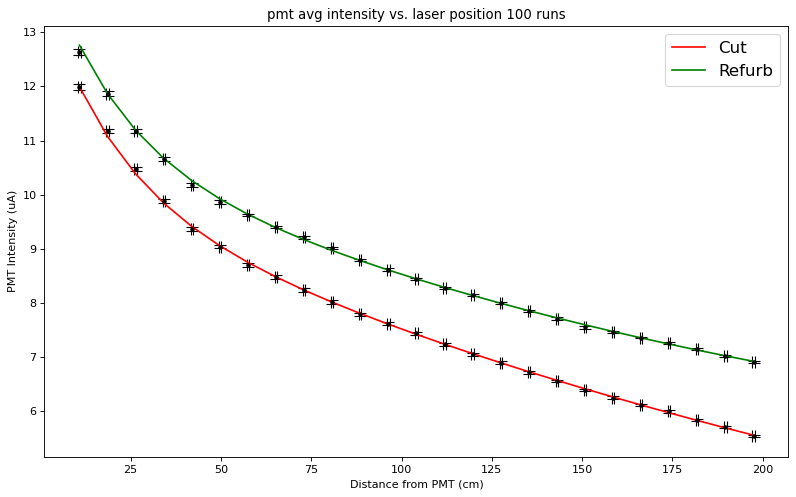

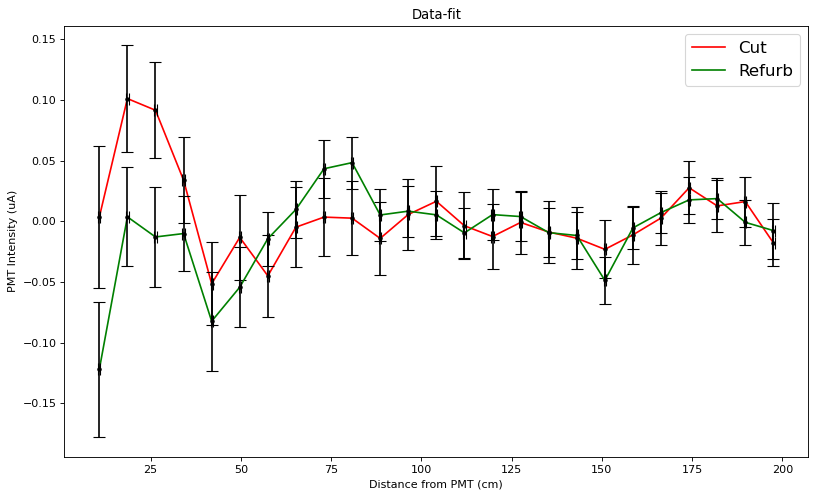

In [15]:
# Joint Fit
fig = plt.figure(figsize=(12, 7), dpi=80)
# plt.plot(pos,pmt_cut_no_outliers_means,color='r')
plt.errorbar(pos,pmt_cut_no_outliers_means, xerr=L_err,yerr=pmt_cut_no_outliers_std, fmt=".", color="k",capsize=5)
# plt.plot(pos,cut_Joint_fit,color='r', linestyle='dashed')
plt.plot(pos,cut_Joint_fit,color='r')
# plt.plot(pos,pmt_ref_no_outliers_means,color='g')
plt.errorbar(pos,pmt_ref_no_outliers_means, xerr=L_err, yerr=pmt_ref_no_outliers_std, fmt=".", color="k",capsize=5)
# plt.plot(pos,ref_Joint_fit,color='g', linestyle='dashed')
plt.plot(pos,ref_Joint_fit,color='g')
plt.title("pmt avg intensity vs. laser position 100 runs")
plt.xlabel("Distance from PMT (cm)")
plt.ylabel("PMT Intensity (uA)")
# plt.legend(['Cut', 'Cut Fit (joint)','Refurb', 'Refurb Fit (joint)'])
plt.legend(['Cut','Refurb'],prop={'size': 15})
plt.show()

# Residuals (data-fit)

fig = plt.figure(figsize=(12, 7), dpi=80)

plt.plot(pos,pmt_cut_no_outliers_means-cut_Joint_fit,color='r')
plt.errorbar(pos,pmt_cut_no_outliers_means-cut_Joint_fit, xerr=L_err,yerr=pmt_cut_no_outliers_std, fmt=".", color="k",capsize=5)

plt.plot(pos,pmt_ref_no_outliers_means-ref_Joint_fit,color='g')
plt.errorbar(pos,pmt_ref_no_outliers_means-ref_Joint_fit, xerr=L_err,yerr=pmt_ref_no_outliers_std, fmt=".", color="k",capsize=5)

plt.title("Data-fit")
plt.xlabel("Distance from PMT (cm)")
plt.ylabel("PMT Intensity (uA)")
plt.legend(['Cut','Refurb'], prop={'size': 15})
plt.show()

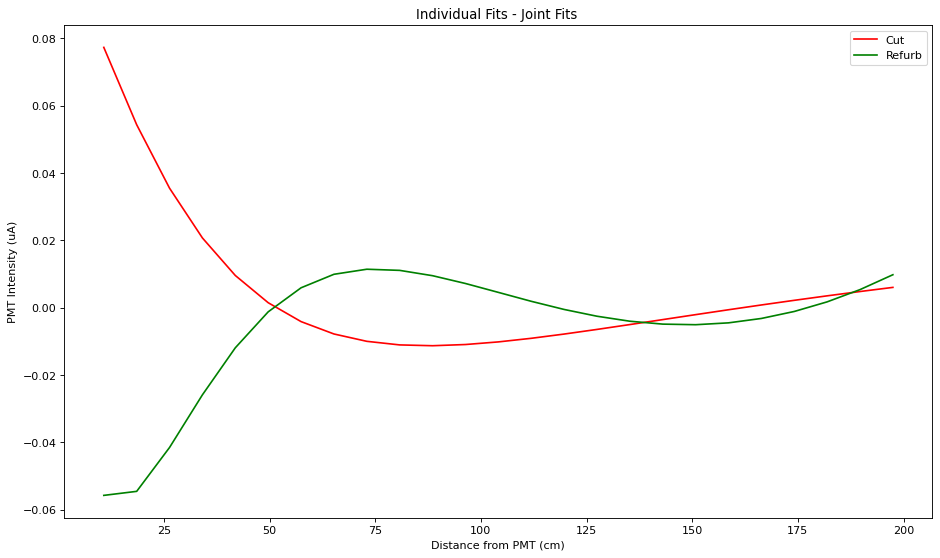

In [11]:
# Residuals (Ind vs Joint)

fig = plt.figure(figsize=(14, 8), dpi=80)
plt.plot(pos,cut_fit-cut_Joint_fit,color='r')
plt.plot(pos,ref_fit-ref_Joint_fit,color='g')
plt.title("Individual Fits - Joint Fits ")
plt.xlabel("Distance from PMT (cm)")
plt.ylabel("PMT Intensity (uA)")
plt.legend(['Cut', 'Refurb'])
plt.show()